# COURSE:   PGP [AI&ML]

## Learner :  Chaitanya Kumar Battula
## Module  : RNN
## Topic   : Automated Trading

# Steps to run an RL agent:

Install Libraries

Fetch the Data

Define the Q-Learning Agent

Train the Agent

Test the Agent

Plot the Signals

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



from collections import deque
import random

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

# Fetch the Data

In [8]:
file = 'GSPC_Training_Dataset.csv'

df = pd.read_csv(file)


df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


# Define the Q-Learning Agent

In [9]:

name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 1  #0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  #0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))
                
                

# Train the Agent

Once the agent is defined, initialize the agent. Specify the number of iterations, initial money, etc to train the agent to decide the buy or sell options.

In [10]:
close = df.Close.values.tolist()

initial_money = 10000
window_size = 30
skip = 1
batch_size = 32

agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)


agent.train(iterations = 1000 , 
            checkpoint = 10, 
            initial_money = initial_money)  #iterations = 200

C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 518.531248.3, cost: 0.395251, total money: 10518.531248
epoch: 20, total rewards: -284.590089.3, cost: 0.220295, total money: 9715.409911
epoch: 30, total rewards: 222.980832.3, cost: 0.186891, total money: 10222.980832
epoch: 40, total rewards: -65.069952.3, cost: 0.124299, total money: 9934.930048
epoch: 50, total rewards: 448.060114.3, cost: 0.120545, total money: 10448.060114
epoch: 60, total rewards: 453.930355.3, cost: 0.110489, total money: 10453.930355
epoch: 70, total rewards: 498.150014.3, cost: 0.096056, total money: 10498.150014
epoch: 80, total rewards: 643.890249.3, cost: 0.087624, total money: 10643.890249
epoch: 90, total rewards: 547.970389.3, cost: 0.077774, total money: 10547.970389
epoch: 100, total rewards: 539.780448.3, cost: 0.068197, total money: 10539.780448
epoch: 110, total rewards: 356.479606.3, cost: 0.062335, total money: 10356.479606
epoch: 120, total rewards: 265.329704.3, cost: 0.069608, total money: 10265.329704
epoch: 130, to

# Test the Agent
The buy function will return the buy, sell, profit, and investment figures.

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 8.145000, total balance 9991.855000
day 4: buy 1 unit at price 8.240000, total balance 9983.615000
day 5: buy 1 unit at price 8.370000, total balance 9975.245000
day 9, sell 1 unit at price 8.890000, investment 9.146714 %, total balance 9984.135000,
day 11: buy 1 unit at price 8.960000, total balance 9975.175000
day 12, sell 1 unit at price 8.995000, investment 9.162623 %, total balance 9984.170000,
day 14: buy 1 unit at price 9.225000, total balance 9974.945000
day 19: buy 1 unit at price 9.125000, total balance 9965.820000
day 20, sell 1 unit at price 9.005000, investment 7.586622 %, total balance 9974.825000,
day 22: buy 1 unit at price 8.875000, total balance 9965.950000
day 25, sell 1 unit at price 8.740000, investment -2.455360 %, total balance 9974.690000,
day 26: buy 1 unit at price 8.555000, total balance 9966.134999
day 32: buy 1 unit at price 8.795000, total balance 9957.339999
day 35, sell 1 unit at price 8.900000, investment -3.523043 %, total ba

day 447: buy 1 unit at price 10.970000, total balance 9992.599998
day 449, sell 1 unit at price 10.670000, investment -2.734733 %, total balance 10003.269998,
day 457: buy 1 unit at price 9.200000, total balance 9994.069998
day 459, sell 1 unit at price 9.310000, investment 1.195659 %, total balance 10003.379998,
day 485: buy 1 unit at price 9.890000, total balance 9993.489998
day 487: buy 1 unit at price 9.940000, total balance 9983.549998
day 489, sell 1 unit at price 10.070000, investment 1.820014 %, total balance 9993.619998,
day 490: buy 1 unit at price 10.030000, total balance 9983.589998
day 491, sell 1 unit at price 10.080000, investment 1.408454 %, total balance 9993.669998,
day 492, sell 1 unit at price 10.130000, investment 0.997013 %, total balance 10003.799998,
day 497: buy 1 unit at price 10.290000, total balance 9993.509998
day 498, sell 1 unit at price 10.240000, investment -0.485911 %, total balance 10003.749998,
day 501: buy 1 unit at price 10.160000, total balance 99

# Plot the calls
Plot the total gains vs the invested figures. All buy and sell calls have been appropriately marked according to the buy/sell options as suggested by the neural network.

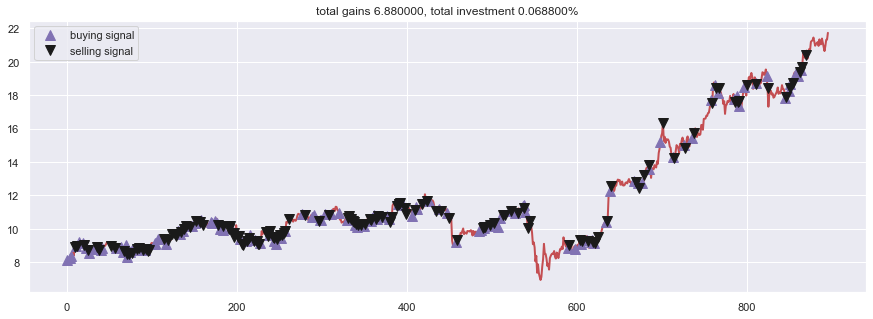

In [6]:
fig = plt.figure(figsize = (15,5))

plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)

plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
#plt.savefig(name+'.png')

plt.show()